table of contents「[Advanced football analytics: building and applying a pitch control model in python.](https://www.youtube.com/watch?v=5X1cSehLg6s)」  
1. Prepare  
2. Read Dataset, Preprocess  
3. Detect Sprint  
4. Calculate added Pitch Control Value each sprint, and Vizualization

# 1. Prepare

## Import Library

In [1]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
cmap = plt.get_cmap('tab10')

## Setting static parameter

In [2]:
sys.path.append(os.path.join('..', 'src'))

import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc

data_dir = os.path.join('..', '..', 'sample-data', 'data')
game_id = 2

# Read Dataset, Preprocess

In [3]:
# read in the event data
events_df = mio.read_event_data(data_dir, game_id)

# read in tracking data
tracking_home_df = mio.tracking_data(data_dir, game_id, 'Home')
tracking_away_df = mio.tracking_data(data_dir, game_id, 'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home_df = mio.to_metric_coordinates(tracking_home_df)
tracking_away_df = mio.to_metric_coordinates(tracking_away_df)
events_df = mio.to_metric_coordinates(events_df)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home_df, tracking_away_df, events_df = mio.to_single_playing_direction(tracking_home_df, tracking_away_df, events_df)

# Calculate player velocities
tracking_home_df = mvel.calc_player_velocities(tracking_home_df, smoothing=True, filter_='moving_average')
tracking_away_df = mvel.calc_player_velocities(tracking_away_df, smoothing=True, filter_='moving_average')

Reading team: home
Reading team: away


# Detect Sprint

## prepare

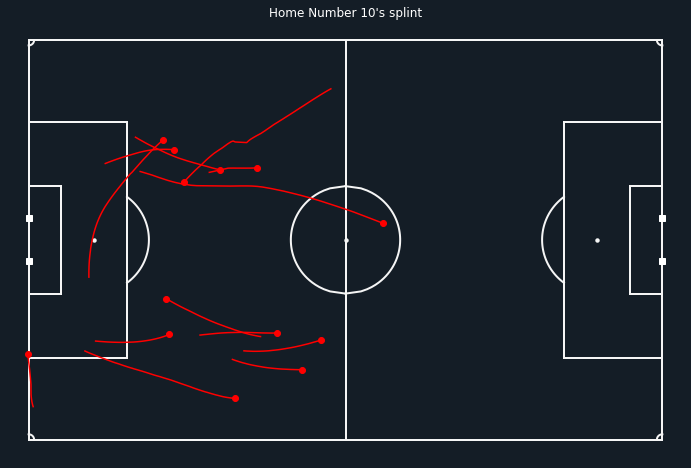

In [16]:
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)

player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position

# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home_df[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
# now plot all the sprints
fig, ax = mviz.plot_pitch(field_color='twitter_dark_mode')
for s, e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home_df[column_x].iloc[s],tracking_home_df[column_y].iloc[s],'ro')
    ax.plot(tracking_home_df[column_x].iloc[s:e+1],tracking_home_df[column_y].iloc[s:e+1],'r')

ax.set_title('Home Number 10\'s splint', color='w')

ax.spines['top'].set_visible(False); ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False); ax.spines['righat'].set_visible(False)

plt.savefig(os.path.join('..', 'reports', 'figure', f'sprint_Home{player}_game_id={game_id}.png'), facecolor=ax.get_facecolor(), bbox_inches='tight')

## first get model parameters

In [10]:
params = mpc.default_model_params(3)

In [11]:
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

## evaluate first pass

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c26980470>)

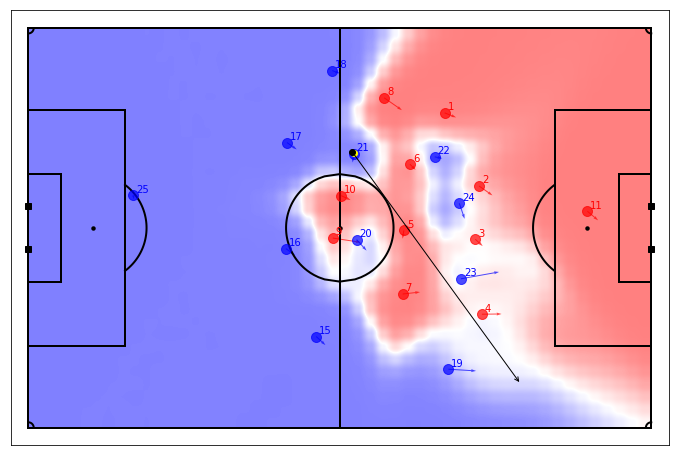

In [12]:
# evaluated pitch control surface for first pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(820, events_df, tracking_home_df, tracking_away_df, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event(820, events_df,  tracking_home_df, tracking_away_df, PPCF, xgrid, ygrid, annotate=True )

## evaluate first pass

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2a1fd2b0>)

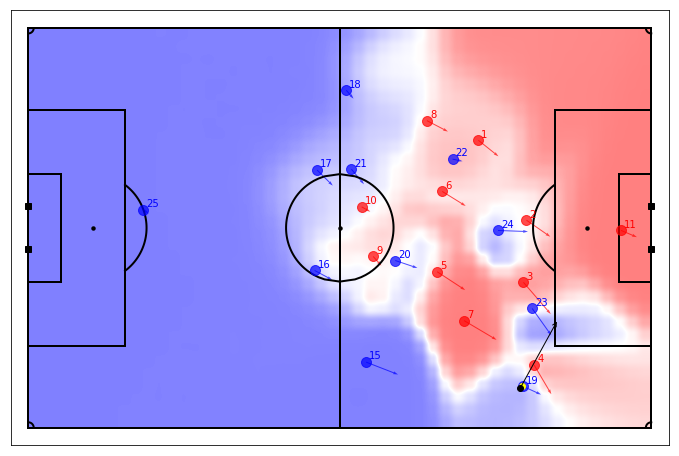

In [14]:
# evaluated pitch control surface for second pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(821, events_df, tracking_home_df, tracking_away_df, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event(821, events_df, tracking_home_df, tracking_away_df, PPCF, xgrid, ygrid, annotate=True)

## evaluate third pass

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c26975278>)

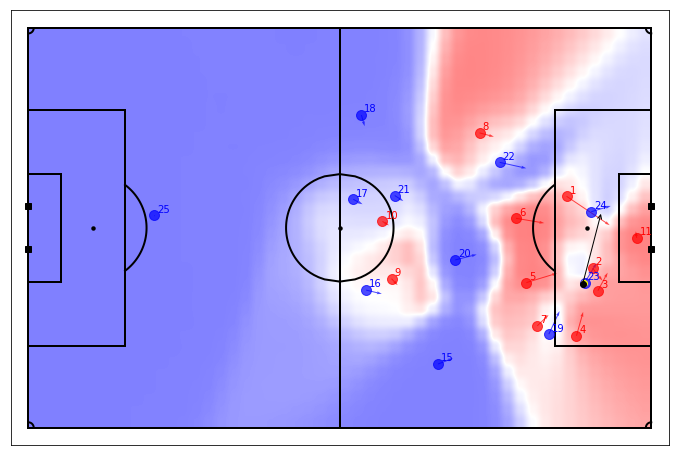

In [15]:
# evaluated pitch control surface for third pass
PPCF, xgrid, ygrid = mpc.generate_pitch_control_for_event(822, events_df, tracking_home_df, tracking_away_df, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event(822, events_df,  tracking_home_df, tracking_away_df, PPCF, xgrid, ygrid, annotate=True )

# Calculate pass probability, and Visualization

In [16]:
# get all home passes
home_passes_df = events_df[ (events_df['Type'].isin(['PASS'])) & (events_df['Team']=='Home') ]

# list for storing pass probablities
pass_success_probability_list = []

for i,row in home_passes_df.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home_df.loc[pass_frame],'Home',params)
    defending_players = mpc.initialise_players(tracking_away_df.loc[pass_frame],'Away',params)
    Patt, Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability_list.append( (i,Patt) )

Text(0,0.5,'Frequency')

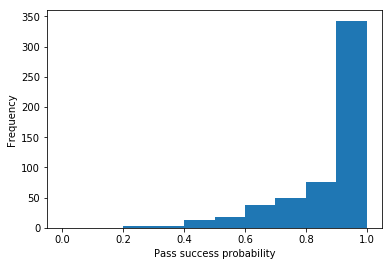

In [17]:
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability_list], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1d185390>)

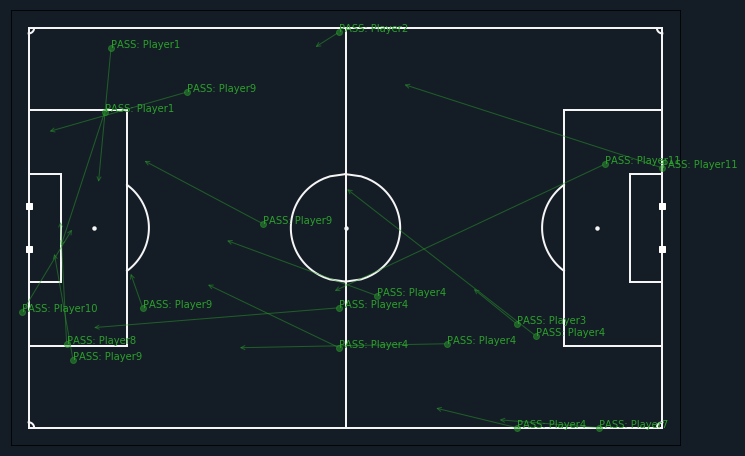

In [19]:
# sort the passes by pitch control probability
pass_success_probability_list = sorted( pass_success_probability_list, key = lambda x: x[1] )

# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events_df.loc[ [p[0] for p in pass_success_probability_list if p[1]<0.5 ] ]

# plot the events
mviz.plot_events(risky_passes, figax=mviz.plot_pitch(field_color='twitter_dark_mode'), color=cmap(2), indicators = ['Marker','Arrow'], annotate=True )

In [22]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability_list[:20]:
    outcome = events_df.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass
0.26940888334951524 CHALLENGE
0.26977947525823215 SHOT
0.28355266004589275 BALL LOST
0.3118934257505092 CHALLENGE
0.33794938339419445 CHALLENGE
0.3882116886003005 SHOT
0.4120563552080869 CHALLENGE
0.4147820093582791 PASS
0.41861866721726027 PASS
0.4223978488361042 BALL LOST
0.431819076300889 CHALLENGE
0.44891911188416955 CHALLENGE
0.4610008848168425 CHALLENGE
0.46834301223806296 CHALLENGE
0.4687260445893318 SHOT
0.48894619695173597 CHALLENGE
0.4901175118019355 CHALLENGE
0.49387354493834146 SHOT
0.4985384467298248 PASS
0.5040960761022257 PASS
